In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
from UnarySim.sw.kernel.sqrt import UnarySqrt
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rng = "Sobol"

In [4]:
def test(col = 10000, bitwidth = 8, jk_trace = False, emit = True, input_075 = True):
    modes = ["unipolar", "bipolar"]
    bstype = torch.float
    randtype = torch.float
    depth_emit = 3
    for mode in modes:
        input = torch.tensor([x for x in range(2**bitwidth)]).type(torch.float).div(2**bitwidth).to(device)
        if input_075 is True:
            input = torch.tensor([x for x in range(2**(bitwidth-2), 2**bitwidth)]).type(torch.float).div(2**bitwidth).to(device)

        dut_sqrt = UnarySqrt(mode=mode, jk_trace=jk_trace, depth=4, rng="Sobol", rng_dim=4, emit=emit, depth_emit=depth_emit, bstype=torch.float).to(device)

        output = torch.sqrt(input).to(device)

        outPE = ProgressiveError(output, mode=mode).to(device)

        inputPE = ProgressiveError(input, mode=mode).to(device)
        inputSRC = SourceGen(input, bitwidth, mode=mode, randtype=randtype)().to(device)
        inputRNG = RNG(bitwidth, 1, rng, randtype)().to(device)
        inputBS = BSGen(inputSRC, inputRNG, bstype).to(device)

        with torch.no_grad():
            start_time = time.time()
            for i in range(2**bitwidth):
                input_bs = inputBS(torch.tensor([i]))
                inputPE.Monitor(input_bs)

                out_bs = dut_sqrt(input_bs)
                outPE.Monitor(out_bs)
            print("--- %s seconds ---" % (time.time() - start_time))
            print("input error: ", torch.min(inputPE()[1]), torch.max(inputPE()[1]))

            print("output error: ", torch.min(outPE()[1]), torch.max(outPE()[1]))


            result_pe = outPE()[1].view(-1).cpu().numpy()
            print("RMSE", math.sqrt(sum(result_pe**2)/len(result_pe)))
            print("MAE", np.mean(np.abs(result_pe)))
            print("bias", np.mean(result_pe))
            fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
            plt.title("Histogram for final output error")
            plt.show()

7
--- 1.1339995861053467 seconds ---
input error:  tensor(0., device='cuda:0') tensor(0., device='cuda:0')
output error:  tensor(-0.0020, device='cuda:0') tensor(0.1875, device='cuda:0')
input: tensor([0.2500, 0.2539, 0.2578, 0.2617, 0.2656, 0.2695, 0.2734, 0.2773, 0.2812,
        0.2852, 0.2891, 0.2930, 0.2969, 0.3008, 0.3047, 0.3086, 0.3125, 0.3164,
        0.3203, 0.3242, 0.3281, 0.3320, 0.3359, 0.3398, 0.3438, 0.3477, 0.3516,
        0.3555, 0.3594, 0.3633, 0.3672, 0.3711, 0.3750, 0.3789, 0.3828, 0.3867,
        0.3906, 0.3945, 0.3984, 0.4023, 0.4062, 0.4102, 0.4141, 0.4180, 0.4219,
        0.4258, 0.4297, 0.4336, 0.4375, 0.4414, 0.4453, 0.4492, 0.4531, 0.4570,
        0.4609, 0.4648, 0.4688, 0.4727, 0.4766, 0.4805, 0.4844, 0.4883, 0.4922,
        0.4961, 0.5000, 0.5039, 0.5078, 0.5117, 0.5156, 0.5195, 0.5234, 0.5273,
        0.5312, 0.5352, 0.5391, 0.5430, 0.5469, 0.5508, 0.5547, 0.5586, 0.5625,
        0.5664, 0.5703, 0.5742, 0.5781, 0.5820, 0.5859, 0.5898, 0.5938, 0.5977,
      

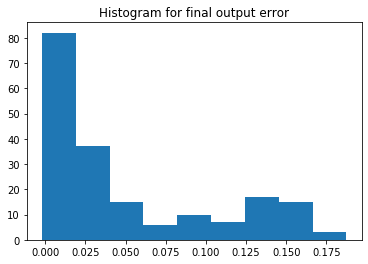

7
--- 1.4569990634918213 seconds ---
input error:  tensor(-0.0039, device='cuda:0') tensor(0.0039, device='cuda:0')
output error:  tensor(-0.0624, device='cuda:0') tensor(0.1018, device='cuda:0')
input: tensor([0.2500, 0.2539, 0.2578, 0.2617, 0.2656, 0.2695, 0.2734, 0.2773, 0.2812,
        0.2852, 0.2891, 0.2930, 0.2969, 0.3008, 0.3047, 0.3086, 0.3125, 0.3164,
        0.3203, 0.3242, 0.3281, 0.3320, 0.3359, 0.3398, 0.3438, 0.3477, 0.3516,
        0.3555, 0.3594, 0.3633, 0.3672, 0.3711, 0.3750, 0.3789, 0.3828, 0.3867,
        0.3906, 0.3945, 0.3984, 0.4023, 0.4062, 0.4102, 0.4141, 0.4180, 0.4219,
        0.4258, 0.4297, 0.4336, 0.4375, 0.4414, 0.4453, 0.4492, 0.4531, 0.4570,
        0.4609, 0.4648, 0.4688, 0.4727, 0.4766, 0.4805, 0.4844, 0.4883, 0.4922,
        0.4961, 0.5000, 0.5039, 0.5078, 0.5117, 0.5156, 0.5195, 0.5234, 0.5273,
        0.5312, 0.5352, 0.5391, 0.5430, 0.5469, 0.5508, 0.5547, 0.5586, 0.5625,
        0.5664, 0.5703, 0.5742, 0.5781, 0.5820, 0.5859, 0.5898, 0.5938, 0.597

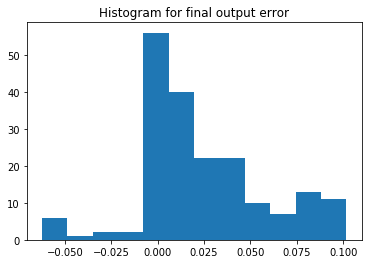

In [5]:
test(col = 10000, bitwidth = 8, emit = True, jk_trace = False, input_075 = True)

--- 0.549999475479126 seconds ---
input error:  tensor(0., device='cuda:0') tensor(0., device='cuda:0')
output error:  tensor(-0.2500, device='cuda:0') tensor(0.0020, device='cuda:0')
input: tensor([0.2500, 0.2539, 0.2578, 0.2617, 0.2656, 0.2695, 0.2734, 0.2773, 0.2812,
        0.2852, 0.2891, 0.2930, 0.2969, 0.3008, 0.3047, 0.3086, 0.3125, 0.3164,
        0.3203, 0.3242, 0.3281, 0.3320, 0.3359, 0.3398, 0.3438, 0.3477, 0.3516,
        0.3555, 0.3594, 0.3633, 0.3672, 0.3711, 0.3750, 0.3789, 0.3828, 0.3867,
        0.3906, 0.3945, 0.3984, 0.4023, 0.4062, 0.4102, 0.4141, 0.4180, 0.4219,
        0.4258, 0.4297, 0.4336, 0.4375, 0.4414, 0.4453, 0.4492, 0.4531, 0.4570,
        0.4609, 0.4648, 0.4688, 0.4727, 0.4766, 0.4805, 0.4844, 0.4883, 0.4922,
        0.4961, 0.5000, 0.5039, 0.5078, 0.5117, 0.5156, 0.5195, 0.5234, 0.5273,
        0.5312, 0.5352, 0.5391, 0.5430, 0.5469, 0.5508, 0.5547, 0.5586, 0.5625,
        0.5664, 0.5703, 0.5742, 0.5781, 0.5820, 0.5859, 0.5898, 0.5938, 0.5977,
        0

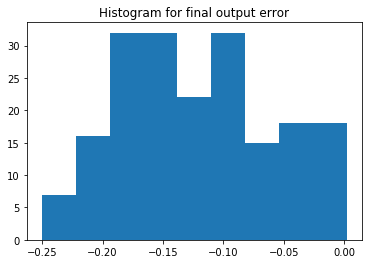

--- 0.7309980392456055 seconds ---
input error:  tensor(-0.0039, device='cuda:0') tensor(0.0039, device='cuda:0')
output error:  tensor(-0.1289, device='cuda:0') tensor(0.0457, device='cuda:0')
input: tensor([0.2500, 0.2539, 0.2578, 0.2617, 0.2656, 0.2695, 0.2734, 0.2773, 0.2812,
        0.2852, 0.2891, 0.2930, 0.2969, 0.3008, 0.3047, 0.3086, 0.3125, 0.3164,
        0.3203, 0.3242, 0.3281, 0.3320, 0.3359, 0.3398, 0.3438, 0.3477, 0.3516,
        0.3555, 0.3594, 0.3633, 0.3672, 0.3711, 0.3750, 0.3789, 0.3828, 0.3867,
        0.3906, 0.3945, 0.3984, 0.4023, 0.4062, 0.4102, 0.4141, 0.4180, 0.4219,
        0.4258, 0.4297, 0.4336, 0.4375, 0.4414, 0.4453, 0.4492, 0.4531, 0.4570,
        0.4609, 0.4648, 0.4688, 0.4727, 0.4766, 0.4805, 0.4844, 0.4883, 0.4922,
        0.4961, 0.5000, 0.5039, 0.5078, 0.5117, 0.5156, 0.5195, 0.5234, 0.5273,
        0.5312, 0.5352, 0.5391, 0.5430, 0.5469, 0.5508, 0.5547, 0.5586, 0.5625,
        0.5664, 0.5703, 0.5742, 0.5781, 0.5820, 0.5859, 0.5898, 0.5938, 0.5977,

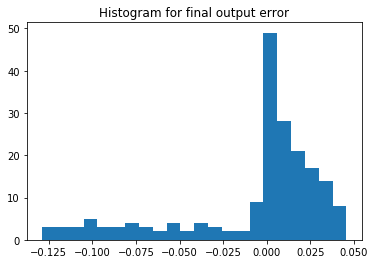

In [6]:
test(col = 10000, bitwidth = 8, emit = False, jk_trace = True, input_075 = True)

--- 0.7039985656738281 seconds ---
input error:  tensor(0., device='cuda:0') tensor(0., device='cuda:0')
output error:  tensor(-0.1289, device='cuda:0') tensor(0.0440, device='cuda:0')
input: tensor([0.2500, 0.2539, 0.2578, 0.2617, 0.2656, 0.2695, 0.2734, 0.2773, 0.2812,
        0.2852, 0.2891, 0.2930, 0.2969, 0.3008, 0.3047, 0.3086, 0.3125, 0.3164,
        0.3203, 0.3242, 0.3281, 0.3320, 0.3359, 0.3398, 0.3438, 0.3477, 0.3516,
        0.3555, 0.3594, 0.3633, 0.3672, 0.3711, 0.3750, 0.3789, 0.3828, 0.3867,
        0.3906, 0.3945, 0.3984, 0.4023, 0.4062, 0.4102, 0.4141, 0.4180, 0.4219,
        0.4258, 0.4297, 0.4336, 0.4375, 0.4414, 0.4453, 0.4492, 0.4531, 0.4570,
        0.4609, 0.4648, 0.4688, 0.4727, 0.4766, 0.4805, 0.4844, 0.4883, 0.4922,
        0.4961, 0.5000, 0.5039, 0.5078, 0.5117, 0.5156, 0.5195, 0.5234, 0.5273,
        0.5312, 0.5352, 0.5391, 0.5430, 0.5469, 0.5508, 0.5547, 0.5586, 0.5625,
        0.5664, 0.5703, 0.5742, 0.5781, 0.5820, 0.5859, 0.5898, 0.5938, 0.5977,
        

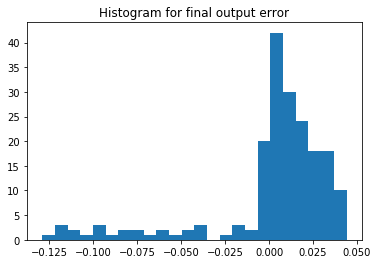

--- 0.8679981231689453 seconds ---
input error:  tensor(-0.0039, device='cuda:0') tensor(0.0039, device='cuda:0')
output error:  tensor(-0.0038, device='cuda:0') tensor(0.1250, device='cuda:0')
input: tensor([0.2500, 0.2539, 0.2578, 0.2617, 0.2656, 0.2695, 0.2734, 0.2773, 0.2812,
        0.2852, 0.2891, 0.2930, 0.2969, 0.3008, 0.3047, 0.3086, 0.3125, 0.3164,
        0.3203, 0.3242, 0.3281, 0.3320, 0.3359, 0.3398, 0.3438, 0.3477, 0.3516,
        0.3555, 0.3594, 0.3633, 0.3672, 0.3711, 0.3750, 0.3789, 0.3828, 0.3867,
        0.3906, 0.3945, 0.3984, 0.4023, 0.4062, 0.4102, 0.4141, 0.4180, 0.4219,
        0.4258, 0.4297, 0.4336, 0.4375, 0.4414, 0.4453, 0.4492, 0.4531, 0.4570,
        0.4609, 0.4648, 0.4688, 0.4727, 0.4766, 0.4805, 0.4844, 0.4883, 0.4922,
        0.4961, 0.5000, 0.5039, 0.5078, 0.5117, 0.5156, 0.5195, 0.5234, 0.5273,
        0.5312, 0.5352, 0.5391, 0.5430, 0.5469, 0.5508, 0.5547, 0.5586, 0.5625,
        0.5664, 0.5703, 0.5742, 0.5781, 0.5820, 0.5859, 0.5898, 0.5938, 0.5977,

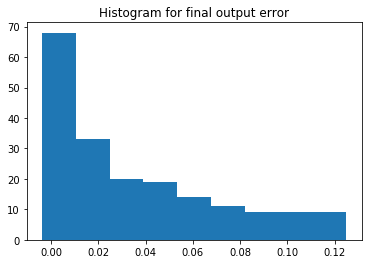

In [7]:
test(col = 10000, bitwidth = 8, emit = False, jk_trace = False, input_075 = True)

--- 0.5610001087188721 seconds ---
input error:  tensor(-0.0039, device='cuda:0') tensor(0., device='cuda:0')
output error:  tensor(-0.2500, device='cuda:0') tensor(0.0020, device='cuda:0')
input: tensor([0.0000, 0.0039, 0.0078, 0.0117, 0.0156, 0.0195, 0.0234, 0.0273, 0.0312,
        0.0352, 0.0391, 0.0430, 0.0469, 0.0508, 0.0547, 0.0586, 0.0625, 0.0664,
        0.0703, 0.0742, 0.0781, 0.0820, 0.0859, 0.0898, 0.0938, 0.0977, 0.1016,
        0.1055, 0.1094, 0.1133, 0.1172, 0.1211, 0.1250, 0.1289, 0.1328, 0.1367,
        0.1406, 0.1445, 0.1484, 0.1523, 0.1562, 0.1602, 0.1641, 0.1680, 0.1719,
        0.1758, 0.1797, 0.1836, 0.1875, 0.1914, 0.1953, 0.1992, 0.2031, 0.2070,
        0.2109, 0.2148, 0.2188, 0.2227, 0.2266, 0.2305, 0.2344, 0.2383, 0.2422,
        0.2461, 0.2500, 0.2539, 0.2578, 0.2617, 0.2656, 0.2695, 0.2734, 0.2773,
        0.2812, 0.2852, 0.2891, 0.2930, 0.2969, 0.3008, 0.3047, 0.3086, 0.3125,
        0.3164, 0.3203, 0.3242, 0.3281, 0.3320, 0.3359, 0.3398, 0.3438, 0.3477,
   

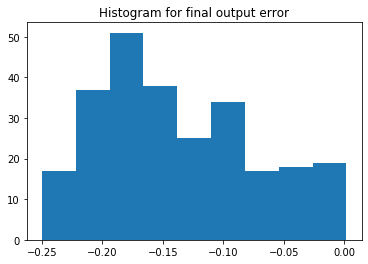

--- 0.7359991073608398 seconds ---
input error:  tensor(-0.0039, device='cuda:0') tensor(0.0039, device='cuda:0')
output error:  tensor(-0.1725, device='cuda:0') tensor(0.0457, device='cuda:0')
input: tensor([0.0000, 0.0039, 0.0078, 0.0117, 0.0156, 0.0195, 0.0234, 0.0273, 0.0312,
        0.0352, 0.0391, 0.0430, 0.0469, 0.0508, 0.0547, 0.0586, 0.0625, 0.0664,
        0.0703, 0.0742, 0.0781, 0.0820, 0.0859, 0.0898, 0.0938, 0.0977, 0.1016,
        0.1055, 0.1094, 0.1133, 0.1172, 0.1211, 0.1250, 0.1289, 0.1328, 0.1367,
        0.1406, 0.1445, 0.1484, 0.1523, 0.1562, 0.1602, 0.1641, 0.1680, 0.1719,
        0.1758, 0.1797, 0.1836, 0.1875, 0.1914, 0.1953, 0.1992, 0.2031, 0.2070,
        0.2109, 0.2148, 0.2188, 0.2227, 0.2266, 0.2305, 0.2344, 0.2383, 0.2422,
        0.2461, 0.2500, 0.2539, 0.2578, 0.2617, 0.2656, 0.2695, 0.2734, 0.2773,
        0.2812, 0.2852, 0.2891, 0.2930, 0.2969, 0.3008, 0.3047, 0.3086, 0.3125,
        0.3164, 0.3203, 0.3242, 0.3281, 0.3320, 0.3359, 0.3398, 0.3438, 0.3477,

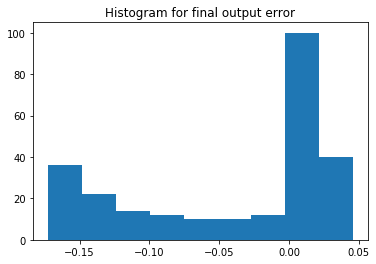

In [8]:
test(col = 10000, bitwidth = 8, emit = False, jk_trace = True, input_075 = False)

--- 0.7059991359710693 seconds ---
input error:  tensor(-0.0039, device='cuda:0') tensor(0., device='cuda:0')
output error:  tensor(-0.1722, device='cuda:0') tensor(0.0440, device='cuda:0')
input: tensor([0.0000, 0.0039, 0.0078, 0.0117, 0.0156, 0.0195, 0.0234, 0.0273, 0.0312,
        0.0352, 0.0391, 0.0430, 0.0469, 0.0508, 0.0547, 0.0586, 0.0625, 0.0664,
        0.0703, 0.0742, 0.0781, 0.0820, 0.0859, 0.0898, 0.0938, 0.0977, 0.1016,
        0.1055, 0.1094, 0.1133, 0.1172, 0.1211, 0.1250, 0.1289, 0.1328, 0.1367,
        0.1406, 0.1445, 0.1484, 0.1523, 0.1562, 0.1602, 0.1641, 0.1680, 0.1719,
        0.1758, 0.1797, 0.1836, 0.1875, 0.1914, 0.1953, 0.1992, 0.2031, 0.2070,
        0.2109, 0.2148, 0.2188, 0.2227, 0.2266, 0.2305, 0.2344, 0.2383, 0.2422,
        0.2461, 0.2500, 0.2539, 0.2578, 0.2617, 0.2656, 0.2695, 0.2734, 0.2773,
        0.2812, 0.2852, 0.2891, 0.2930, 0.2969, 0.3008, 0.3047, 0.3086, 0.3125,
        0.3164, 0.3203, 0.3242, 0.3281, 0.3320, 0.3359, 0.3398, 0.3438, 0.3477,
   

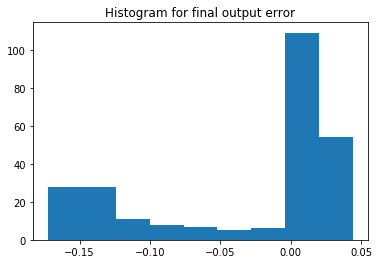

--- 0.8680002689361572 seconds ---
input error:  tensor(-0.0039, device='cuda:0') tensor(0.0039, device='cuda:0')
output error:  tensor(-0.0625, device='cuda:0') tensor(0.4194, device='cuda:0')
input: tensor([0.0000, 0.0039, 0.0078, 0.0117, 0.0156, 0.0195, 0.0234, 0.0273, 0.0312,
        0.0352, 0.0391, 0.0430, 0.0469, 0.0508, 0.0547, 0.0586, 0.0625, 0.0664,
        0.0703, 0.0742, 0.0781, 0.0820, 0.0859, 0.0898, 0.0938, 0.0977, 0.1016,
        0.1055, 0.1094, 0.1133, 0.1172, 0.1211, 0.1250, 0.1289, 0.1328, 0.1367,
        0.1406, 0.1445, 0.1484, 0.1523, 0.1562, 0.1602, 0.1641, 0.1680, 0.1719,
        0.1758, 0.1797, 0.1836, 0.1875, 0.1914, 0.1953, 0.1992, 0.2031, 0.2070,
        0.2109, 0.2148, 0.2188, 0.2227, 0.2266, 0.2305, 0.2344, 0.2383, 0.2422,
        0.2461, 0.2500, 0.2539, 0.2578, 0.2617, 0.2656, 0.2695, 0.2734, 0.2773,
        0.2812, 0.2852, 0.2891, 0.2930, 0.2969, 0.3008, 0.3047, 0.3086, 0.3125,
        0.3164, 0.3203, 0.3242, 0.3281, 0.3320, 0.3359, 0.3398, 0.3438, 0.3477,

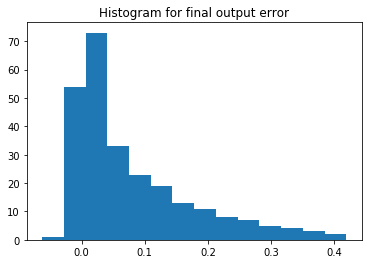

In [9]:
test(col = 10000, bitwidth = 8, emit = False, jk_trace = False, input_075 = False)